# Proyecto Final - Series de Tiempo

#### Una conclusión del proyecto 3 fue que la estacion Illia no se estaba dejando de usar sino que estaba cambiando su forma de pago.
#### En el siguiente proyecto, se buscara comprobar eso y para la creacion de un modelo se utilizara la libreria Prophet de facebook.

In [21]:
import matplotlib
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import fbprophet
from fbprophet import Prophet
sns.set()

In [22]:
data_2020 = pd.read_csv('flujo-vehicular-2020.csv', sep =',')
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

---

Primero vamos a realizar un analisis exploratorio al dataset del año 2020

In [23]:
data_2020.shape

(2297440, 13)

In [24]:
print(data_2020['forma_pago'].unique())

['Efectivo' 'Rec.Deuda' 'Tarjeta Magnética' 'Tag' 'Exento' 'Violación'
 'CPP']


Nos llama la atencion el termino CPP, este significa pejaes sin barreras el cual va a siendo implementando en las distintas estaciones

In [25]:
print(data_2020['estacion'].unique())

['ALBERDI' 'AVELLANEDA' 'DELLEPIANE LINIERSLEPIANE CENTRO'
 'DELLEPIANE LINIERS' 'ILLIA' 'ILP' 'PB1' 'PB3' 'PB4' 'RETIRO' 'SALGUERO'
 'SARMIENTO' 'PB2']


Aca ya podemos ver una diferencia clara de formato con los demas datasets

In [26]:
data_2020.sample(5)

,periodo,fecha,mes,dia,dia_fecha,hora_inicio,hora_fin,estacion,tipo_vehiculo,forma_pago,observacion,sentido,cantidad_pasos
1635564,2020.0,2020-09-04,septiembre,Viernes,4.0,11.0,12.0,ILLIA,Auto,Efectivo,Efectivo,Centro,549
2195724,2020.0,2020-11-10,noviembre,Martes,10.0,17.0,18.0,ILLIA,Pesados 2 Ejes,Tag,Tag - PosPago OCR,Centro,10
2275972,2020.0,2020-11-26,noviembre,Jueves,26.0,1.0,2.0,ILP,Pesados 5 Ejes,Violación,Violación - Normal,Centro,2
1620489,2020.0,2020-08-17,agosto,Lunes,17.0,16.0,17.0,DELLEPIANE LINIERSLEPIANE CENTRO,Pesados 6 Ejes,Tag,Tag - PosPago,Centro,3
1461080,2020.0,2020-08-23,agosto,Domingo,23.0,1.0,2.0,PB1,Auto,Tag,Tag - PosPago,Provincia,2


In [27]:
pd.options.mode.chained_assignment = None  # default='warn'

---

In [28]:
#Unimos los 4 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset_completo = pd.concat([data_2020, data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y todas las formas de pago
estacion = ['Illia', 'ILLIA']
pago = ['EFECTIVO', 'TELEPASE', 'Efectivo', 'Tag','Tarjeta Magnética', 'Exento', 'Violación', 'EXENTO' ,'INFRACCION', 'CPP']
ds_illia = dataset_completo[(dataset_completo.estacion.isin(estacion)) & (dataset_completo.forma_pago.isin(pago))]

#Quitamos las columnas que no vamos a utilizar
ds_illia.drop(columns = ['periodo','hora_inicio', 'estacion', 'dia_fecha', 'observacion'], inplace = True)

ds_illia.sample(10)

,fecha,mes,dia,hora_fin,tipo_vehiculo,forma_pago,sentido,cantidad_pasos
396685,2019-06-07,NaN,Viernes,2.0,Pesado,EFECTIVO,Provincia,3
1046278,2020-06-24,junio,Miércoles,23.0,Auto,Efectivo,Provincia,52
1863042,2020-10-07,octubre,Miércoles,21.0,Auto,Efectivo,Provincia,59
1203098,2017-11-16,NaN,Jueves,10.0,Pesado,TELEPASE,Centro,2
321445,2020-02-10 00:00:00,febrero,Lunes,22.0,Auto,Tag,Centro,442
1698277,2020-09-01,septiembre,Martes,7.0,Moto,Efectivo,Centro,8
483061,2017-05-09,NaN,Martes,10.0,Liviano,EFECTIVO,Provincia,90
124123,2017-02-02,NaN,Jueves,15.0,Pesado,EFECTIVO,Provincia,2
832922,2020-05-09,mayo,Sábado,21.0,Auto,Tag,Centro,97
1570483,2020-08-29,agosto,Sábado,7.0,Pesados 3 Ejes,Tag,Centro,1


In [29]:
ds_illia.shape

(866710, 8)

In [30]:
efectivo = ['EFECTIVO', 'Efectivo']
automaticas = ['TELEPASE', 'Tag', 'Tarjeta Magnética', 'CPP']
exentos = ['Exento','EXENTO' ]
infracciones = ['Violación', 'INFRACCION' ]

Separamos los dataset en las distintas formas de pago y se deciden agregar a los exentos y las infranciones para ver si el cambio en la forma de pago ha influido tambien en ellos

In [31]:
ds_efectivo = ds_illia[(ds_illia.forma_pago.isin(efectivo))]

In [32]:
automaticas = ds_illia[(ds_illia.forma_pago.isin(automaticas))]

In [33]:
exentos = ds_illia[(ds_illia.forma_pago.isin(exentos))]

In [34]:
infracciones = ds_illia[(ds_illia.forma_pago.isin(infracciones))]

In [35]:
ds_illia.head(2)

,fecha,mes,dia,hora_fin,tipo_vehiculo,forma_pago,sentido,cantidad_pasos
52,2020-01-01 00:00:00,enero,Miércoles,1.0,Auto,Efectivo,Centro,326
53,2020-01-01 00:00:00,enero,Miércoles,1.0,Auto,Efectivo,Provincia,319


In [36]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
ds_illia['Fecha2'] = pd.to_datetime(ds_illia.fecha) + pd.to_timedelta(ds_illia.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
ds_illia.drop(columns=['fecha','hora_fin'], inplace = True)

ds_illia.head()

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,Fecha2
52,enero,Miércoles,Auto,Efectivo,Centro,326,2020-01-01 01:00:00
53,enero,Miércoles,Auto,Efectivo,Provincia,319,2020-01-01 01:00:00
54,enero,Miércoles,Auto,Exento,Centro,2,2020-01-01 01:00:00
55,enero,Miércoles,Auto,Exento,Provincia,1,2020-01-01 01:00:00
60,enero,Miércoles,Auto,Tarjeta Magnética,Centro,1,2020-01-01 01:00:00


In [37]:
#Hacemos lo mismo para los ds de efectivo y telepase
#Efectivo
ds_efectivo['Fecha2'] = pd.to_datetime(ds_efectivo.fecha) + pd.to_timedelta(ds_efectivo.hora_fin, unit = 'h')


ds_efectivo.drop(columns=['fecha','hora_fin'], inplace = True)



#Automaticas
automaticas['Fecha2'] = pd.to_datetime(automaticas.fecha) + pd.to_timedelta(automaticas.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
automaticas.drop(columns=['fecha','hora_fin'], inplace = True)



#Exentos
exentos['Fecha2'] = pd.to_datetime(exentos.fecha) + pd.to_timedelta(exentos.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
exentos.drop(columns=['fecha','hora_fin'], inplace = True)


#infracciones
infracciones['Fecha2'] = pd.to_datetime(infracciones.fecha) + pd.to_timedelta(infracciones.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
infracciones.drop(columns=['fecha','hora_fin'], inplace = True)



In [38]:
ds_efectivo.head(2)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,Fecha2
52,enero,Miércoles,Auto,Efectivo,Centro,326,2020-01-01 01:00:00
53,enero,Miércoles,Auto,Efectivo,Provincia,319,2020-01-01 01:00:00


In [39]:
automaticas.head(2)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,Fecha2
60,enero,Miércoles,Auto,Tarjeta Magnética,Centro,1,2020-01-01 01:00:00
61,enero,Miércoles,Auto,Tarjeta Magnética,Provincia,2,2020-01-01 01:00:00


In [40]:
exentos.head(2)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,Fecha2
54,enero,Miércoles,Auto,Exento,Centro,2,2020-01-01 01:00:00
55,enero,Miércoles,Auto,Exento,Provincia,1,2020-01-01 01:00:00


In [41]:
infracciones.head(2)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,Fecha2
70,enero,Miércoles,Auto,Violación,Provincia,1,2020-01-01 01:00:00
1040,enero,Miércoles,Auto,Violación,Provincia,1,2020-01-01 13:00:00


In [42]:
#Corregimos el nombre de fecha2 a fecha
ds_illia.rename(columns = {'Fecha2':'fecha'}, inplace = True) 

ds_efectivo.rename(columns = {'Fecha2':'fecha'}, inplace = True) 

automaticas.rename(columns = {'Fecha2':'fecha'}, inplace = True) 

exentos.rename(columns = {'Fecha2':'fecha'}, inplace = True) 

infracciones.rename(columns = {'Fecha2':'fecha'}, inplace = True) 


In [43]:
#Reordenamos el dataset por fecha
ds_illia.sort_values('fecha', inplace = True)
ds_illia.reset_index(drop=True, inplace = True)

ds_efectivo.sort_values('fecha', inplace = True)
ds_efectivo.reset_index(drop=True, inplace = True)

automaticas.sort_values('fecha', inplace = True)
automaticas.reset_index(drop=True, inplace = True)

exentos.sort_values('fecha', inplace = True)
exentos.reset_index(drop=True, inplace = True)

infracciones.sort_values('fecha', inplace = True)
infracciones.reset_index(drop=True, inplace = True)

In [44]:
ds_illia.sample(3)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha
166388,NaN,Jueves,Liviano,EFECTIVO,Centro,372,2017-08-31 10:00:00
177375,NaN,Domingo,Pesado,EFECTIVO,Provincia,10,2017-09-17 03:00:00
483378,NaN,Jueves,Pesado,TELEPASE,Provincia,1,2018-11-29 16:00:00


In [45]:
ds_efectivo.sample(3)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha
192716,NaN,Viernes,Pesado,EFECTIVO,Centro,1,2018-11-16 17:00:00
2536,NaN,Lunes,Pesado,EFECTIVO,Centro,48,2017-01-09 10:00:00
151528,NaN,Martes,Pesado,EFECTIVO,Centro,2,2018-06-19 20:00:00


In [46]:
automaticas.sample(3)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha
178286,NaN,Domingo,Pesado,TELEPASE,Centro,9,2019-03-31 01:00:00
295602,agosto,Lunes,Auto,Tag,Provincia,3,2020-08-17 18:00:00
299246,agosto,Jueves,Pesados 2 Ejes,Tag,Provincia,1,2020-08-27 00:00:00


In [47]:
exentos.sample(3)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha
68482,NaN,Miércoles,Pesado,EXENTO,Centro,3,2018-10-10 03:00:00
18792,NaN,Sábado,Liviano,EXENTO,Centro,1,2017-06-24 04:00:00
104138,NaN,Domingo,Liviano,EXENTO,Provincia,9,2019-12-08 07:00:00


In [48]:
infracciones.sample(3)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha
84644,marzo,Viernes,Auto,Violación,Centro,4,2020-03-13 19:00:00
82384,febrero,Miércoles,N/D,Violación,Centro,6,2020-02-19 23:00:00
98592,julio,Jueves,N/D,Violación,Centro,291,2020-07-23 07:00:00


#### A continuación, mostraremos tendencias con un resampleo mensual; y luego haremos lo mismo pero separando vehículos livianos y pesados, y ademas con los distintos metodos de pago

In [49]:
ventana = int(365*2/53)

In [50]:
#Resampleamos nuestros datos para agrupar por mes
month_illia = ds_illia.resample('M', on = 'fecha').sum()
print(month_illia.shape)
month_illia.head(5)

(47, 1)


,cantidad_pasos
fecha,
2017-01-31,2602496
2017-02-28,2328794
2017-03-31,2679183
2017-04-30,2518111
2017-05-31,2671084


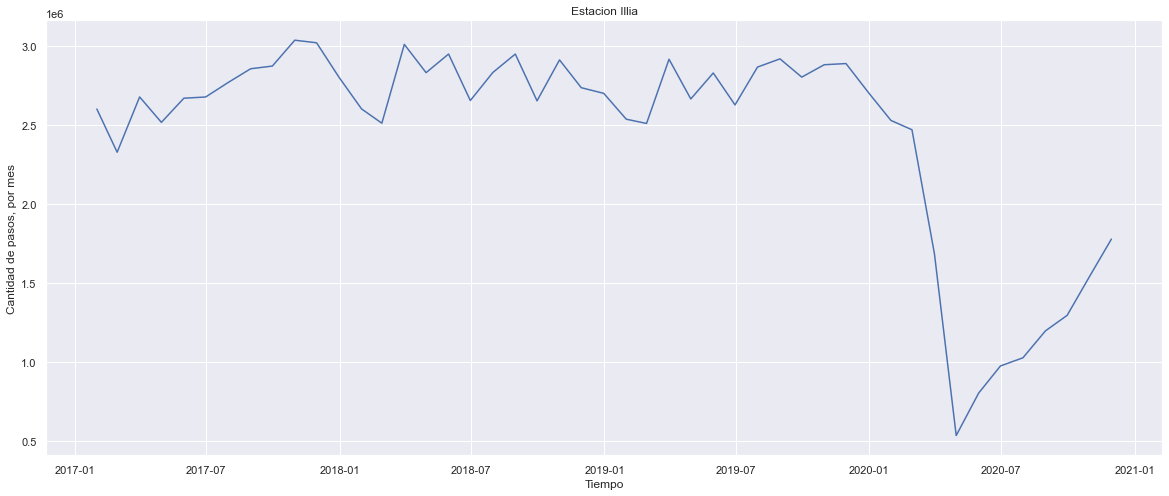

In [51]:
plt.figure(figsize = (20,8))
plt.plot(month_illia.index, month_illia.cantidad_pasos)
plt.title('Estacion Illia')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de pasos, por mes')
plt.show()

Si bien se observa una caida abrupta en el 2020, el grafico no nos dice mucho. Por eso a continuación haremos el promedio

In [52]:
month_average_trend = month_illia.rolling(window=ventana, center = True).mean()

In [53]:
plt.style.use('fivethirtyeight')

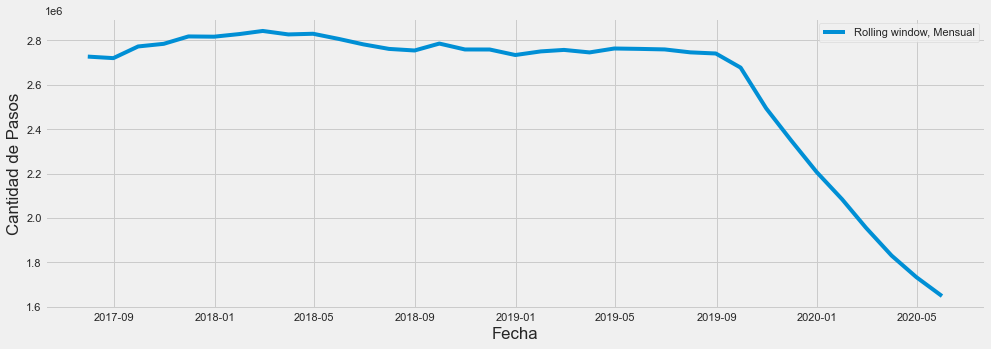

In [54]:
plt.figure(figsize = (15,5))
plt.plot(month_average_trend, lw=4, label = 'Rolling window, Mensual')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

##### En el proyecto 3, cuando analizamos el dataset sin tener en cuenta todos los medios de pago, se marcaba una clara tendencia negativa, lo que nos llevo a concluir que la estación se estaba dejando de usar. Ahora, incluyendo los demas metodos de pago, vemos que en realidad la estación Illia no se está dejando de usar, sino que se ha mantenido su flujo vehicular hasta Setiembre de 2019, donde cae abruptamente. Investigaremos mas adelante el por qué.

---

Ahora vamos a realizar el mismo analisis distinguiendo los distintos medios de pago

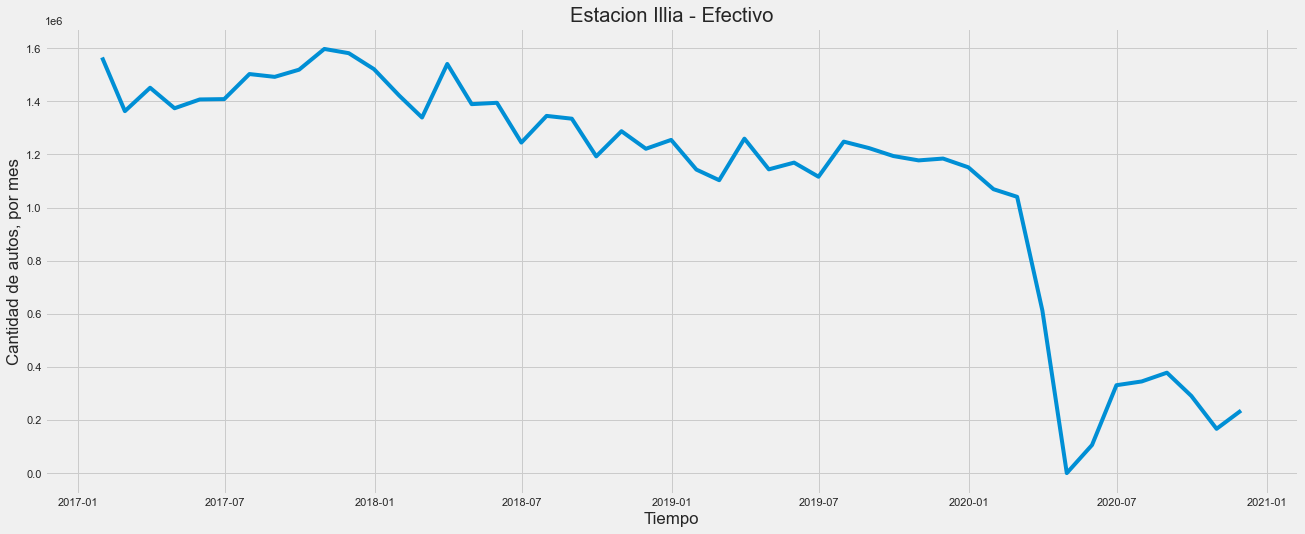

In [55]:
month_efectivo = ds_efectivo.resample('M', on = 'fecha').sum()

plt.figure(figsize = (20,8))
plt.plot(month_efectivo.index, month_efectivo.cantidad_pasos)
plt.title('Estacion Illia - Efectivo')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

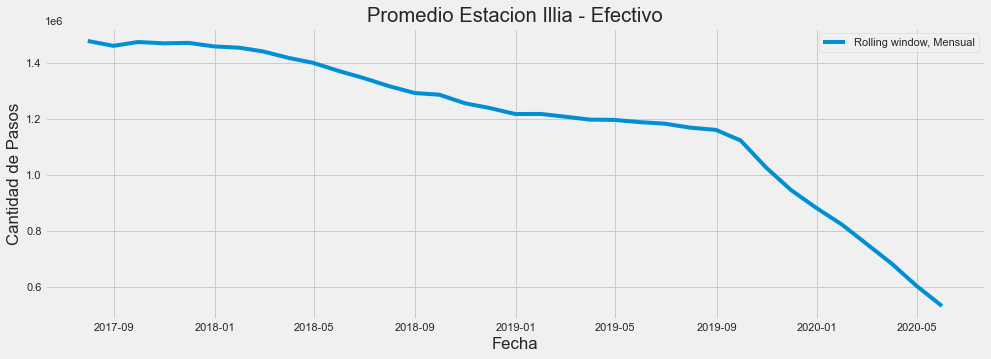

In [56]:
month_efectivo_average_trend = month_efectivo.rolling(window=ventana, center = True).mean()

plt.style.use('fivethirtyeight')

plt.figure(figsize = (15,5))
plt.plot(month_efectivo_average_trend, lw=4, label = 'Rolling window, Mensual')
plt.title('Promedio Estacion Illia - Efectivo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

##### El gráfico anterior refleja que el flujo vehicular viene con una tendencia negativa para este metodo de pago en particular, y afirmando de forma erronea en el proyecto 3 que la estación se está dejando de usar.

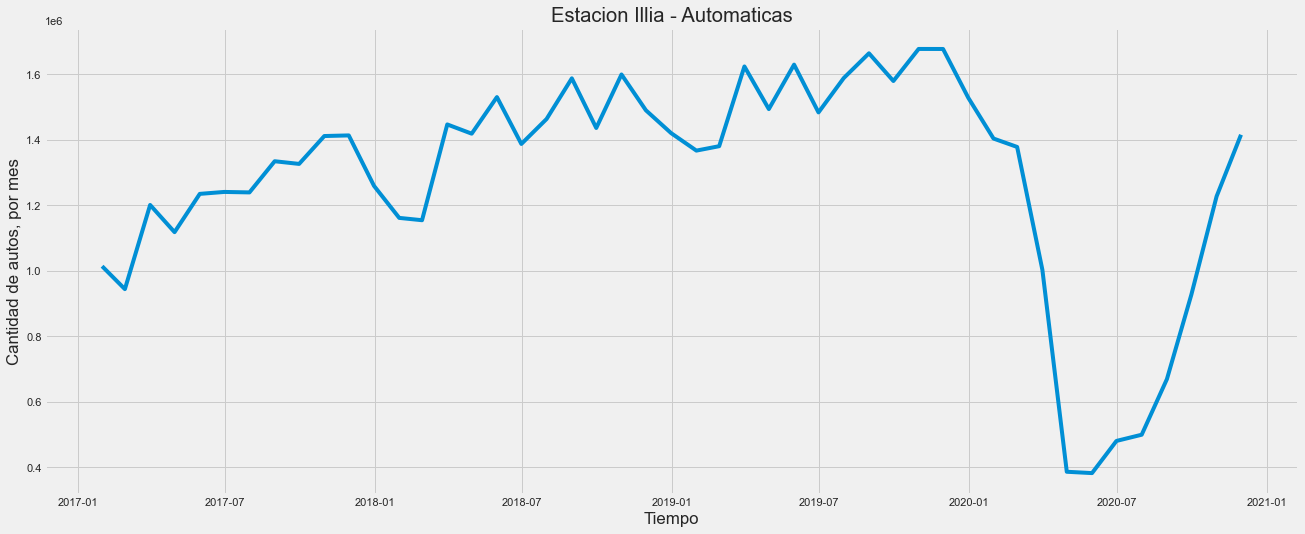

In [57]:
month_automaticas = automaticas.resample('M', on = 'fecha').sum()

plt.figure(figsize = (20,8))
plt.plot(month_automaticas.index, month_automaticas.cantidad_pasos)
plt.title('Estacion Illia - Automaticas')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

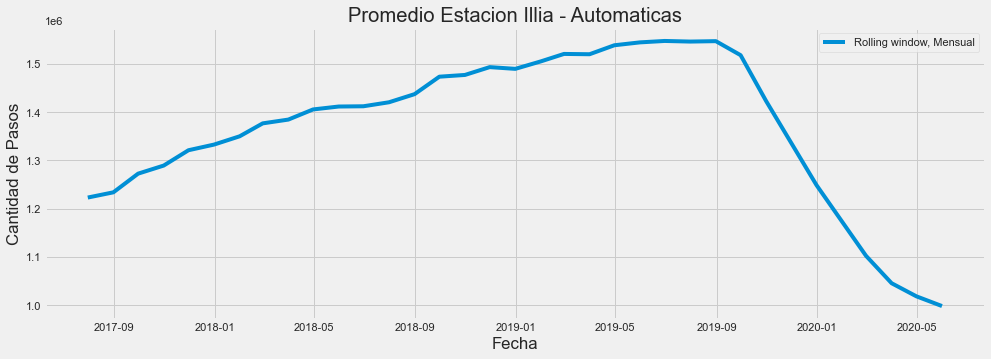

In [58]:
month_automaticas_average_trend = month_automaticas.rolling(window=ventana, center = True).mean()

plt.style.use('fivethirtyeight')

plt.figure(figsize = (15,5))
plt.plot(month_automaticas_average_trend, lw=4, label = 'Rolling window, Mensual')
plt.title('Promedio Estacion Illia - Automaticas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

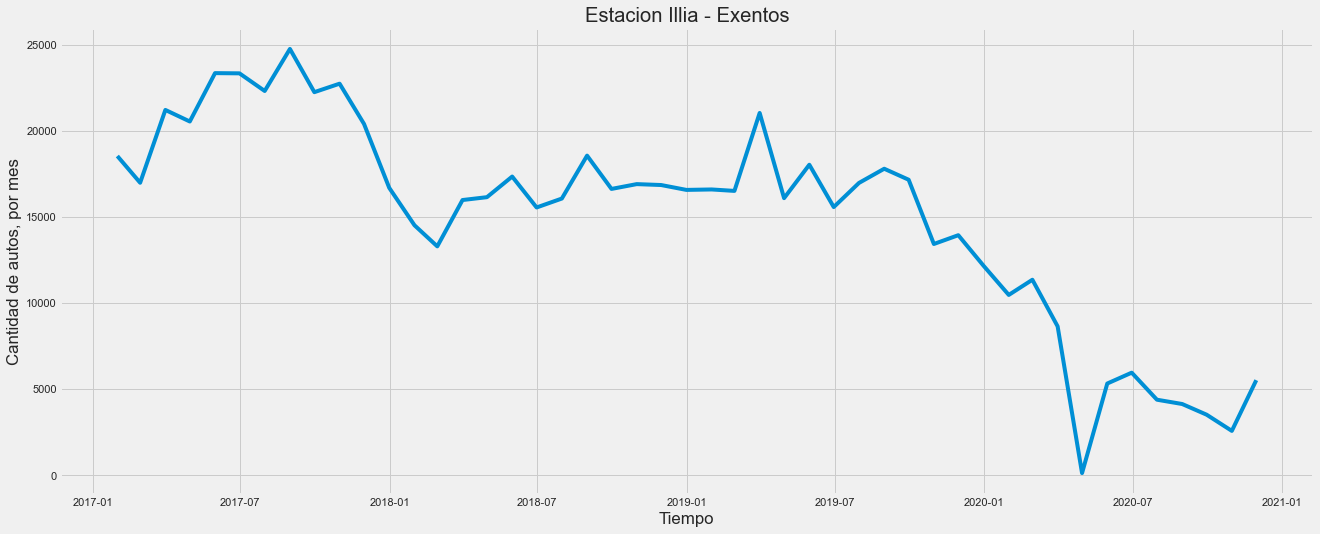

In [59]:
month_exentos = exentos.resample('M', on = 'fecha').sum()

plt.figure(figsize = (20,8))
plt.plot(month_exentos.index, month_exentos.cantidad_pasos)
plt.title('Estacion Illia - Exentos')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

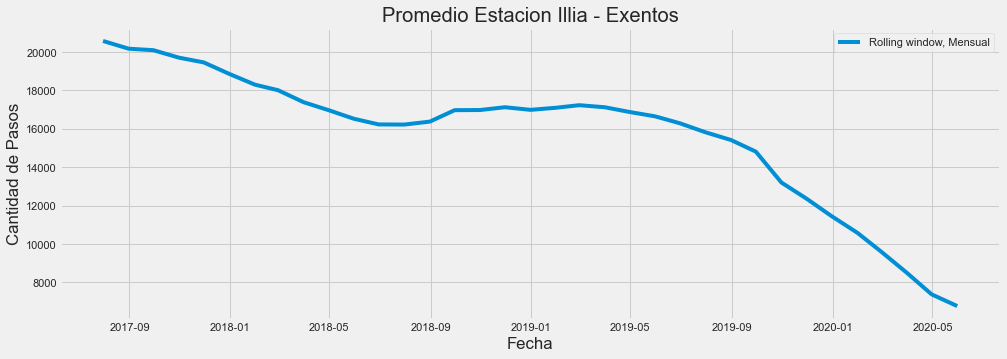

In [60]:
month_exentos_average_trend = month_exentos.rolling(window=ventana, center = True).mean()

plt.style.use('fivethirtyeight')

plt.figure(figsize = (15,5))
plt.plot(month_exentos_average_trend, lw=4, label = 'Rolling window, Mensual')
plt.title('Promedio Estacion Illia - Exentos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

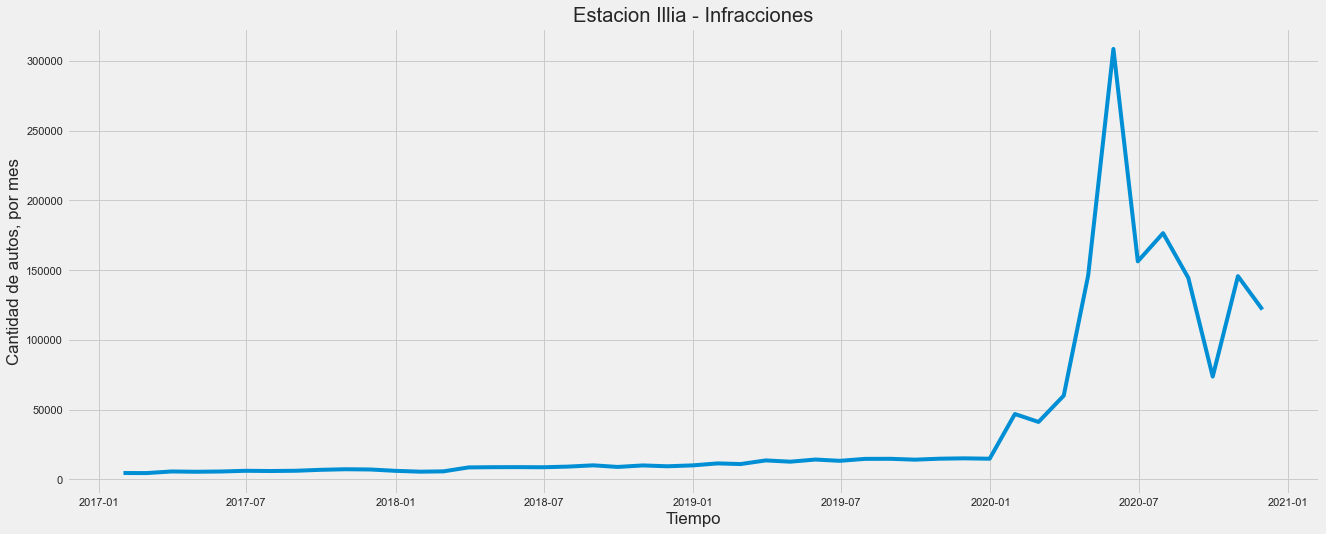

In [61]:
month_infracciones = infracciones.resample('M', on = 'fecha').sum()

plt.figure(figsize = (20,8))
plt.plot(month_infracciones.index, month_infracciones.cantidad_pasos)
plt.title('Estacion Illia - Infracciones')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.show()

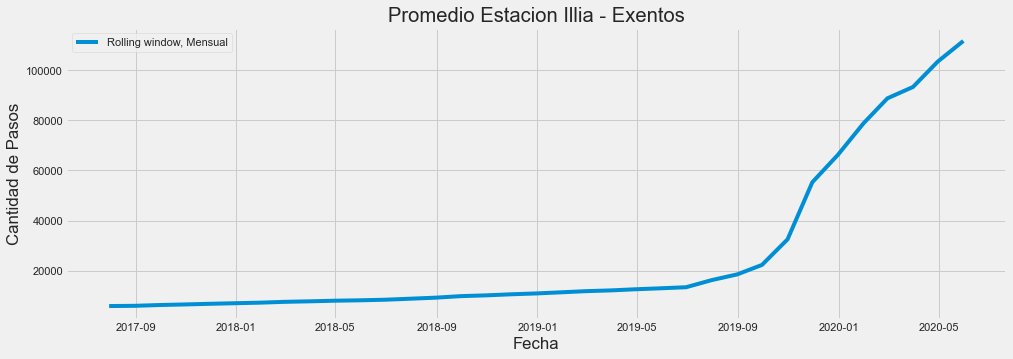

In [62]:
month_infracciones_average_trend = month_infracciones.rolling(window=ventana, center = True).mean()

plt.style.use('fivethirtyeight')

plt.figure(figsize = (15,5))
plt.plot(month_infracciones_average_trend, lw=4, label = 'Rolling window, Mensual')
plt.title('Promedio Estacion Illia - Exentos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

##### Como se puede ver y analizar en los graficos superiores dicha estacion no se esta dejando de usar sino que se estan cambiando las formas de pago. Si bien se observa una marcada disminucion entre septiembre de 2019 a enere de 2020, esto se debe a diversar razones. Algunas de ellas son que debido a la construccion del paseo del bajo esta estacion se usaba menos. Y por otro lado con la obligatoriedad del telepase, hasta que todos pudieron hacerlo y registrarse dichos pasos se registraron como infracciones, lo que explicaria la suba de dicha variable

https://aubasa.com.ar/aubasa-suma-importantes-beneficios-para-usuarios-de-telepase/


https://www.buenosaires.gob.ar/jefaturadegabinete/movilidad/noticias/por-el-alto-numero-de-adhesiones-diarias-habra-tiempo-hasta-el

-----

Ahora separemos por tipo de vehiculo

In [63]:
ds_illia.tipo_vehiculo.unique()

array(['Pesado', 'Liviano', 'Moto', 'Auto', 'Pesados 2 Ejes', 'N/D',
       'Pesados 3 Ejes', 'Pesados 5 Ejes', 'Auto con trailer',
       'Pesados 6 Ejes', 'Pago Doble Auto', 'Pesados 4 Ejes',
       'Pago doble Moto', 'Pago Doble Auto con trailer / Pesado 2 Ejes'],
      dtype=object)

In [64]:
liv = ['Liviano', 'Auto' ,'Auto con trailer', 'Moto' 'N/D' ,'Pago Doble Auto',
 'Pago Doble Auto con trailer / Pesado 2 Ejes', 'Pago doble Moto']
pes = ['Pesado', 'Pesados 2 Ejes', 'Pesados 3 Ejes', 'Pesados 4 Ejes', 'Pesados 5 Ejes',
 'Pesados 6 Ejes']

In [65]:
livianos = ds_illia[ds_illia.tipo_vehiculo.isin(liv)]
pesados = ds_illia[ds_illia.tipo_vehiculo.isin(pes)]

In [66]:
week_liviano = livianos.resample('M', on = 'fecha').sum()
week_pesado = pesados.resample('M', on = 'fecha').sum()

In [67]:
week_average_trend_liviano = week_liviano.rolling(window=ventana, center = True).mean()
week_average_trend_pesado = week_pesado.rolling(window=ventana, center = True).mean()

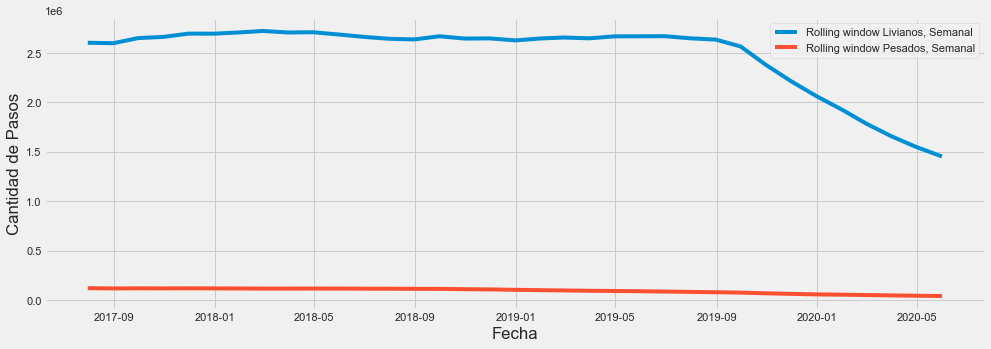

In [68]:
plt.figure(figsize = (15,5))
plt.plot(week_average_trend_liviano, lw=4, label = 'Rolling window Livianos, Semanal')
plt.plot(week_average_trend_pesado, lw=4, label = 'Rolling window Pesados, Semanal')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Pasos')
plt.legend()
plt.show()

Observamos que para vehiculos pesados, existe una tendencia negativa, tendiendo a cero. Para vehiculos livianos el flujo es constante hasta Setiembre de 2019, donde el flujo a caer marcando una tendencia negativa.

No encontramos una razon que explique la dismunucion de vehiculos pesado, se lo atribuimos a los altos costos en caso de no contar con telepase

---

#### Procedemos a hacer la descomposion de la serie en sus tres componentes: Tendencia, Estacionalidad y Ruido

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose

descompose_efectivo = seasonal_decompose(month_efectivo, model='additive')
descompose_automaticas = seasonal_decompose(month_automaticas, model='additive')

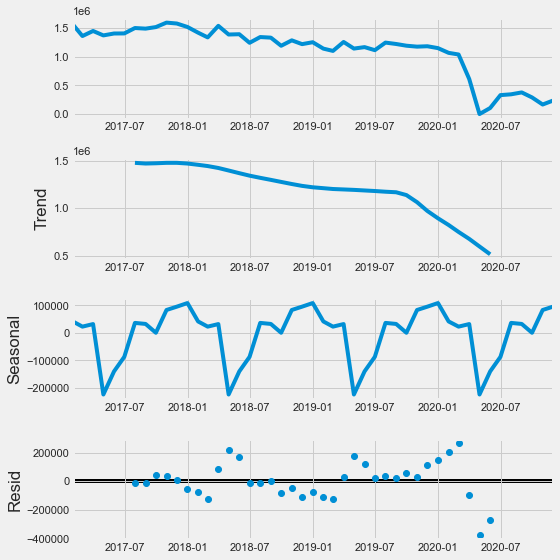

In [70]:
matplotlib.rcParams['figure.figsize'] = [8,8]
descompose_efectivo.plot()
plt.show()

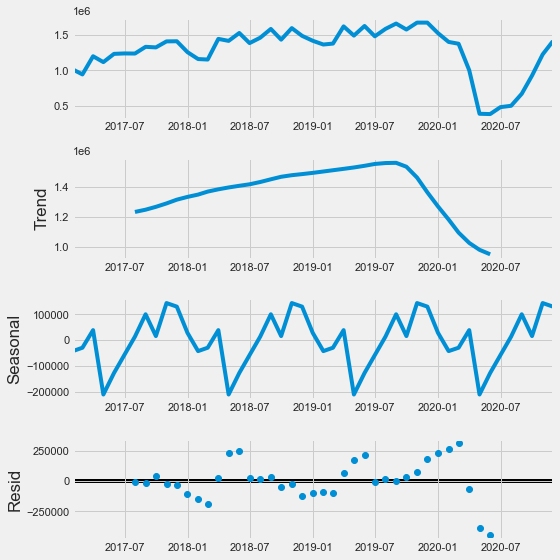

In [71]:
matplotlib.rcParams['figure.figsize'] = [8,8]
descompose_automaticas.plot()
plt.show()

Algo notorio es que el residual de ambas series son muy parecidas, lo que nos dice que existe algo intrinseco entre ambas.

Existe una estacionalidad marcada, con una tendencia positiva desde Mayo hasta Octubre/Noviembre, y luego una tendencia negativa desde Octubre/Noviembre hasta Mayo nuevamente

Y se puede apreciar como las formas automaticas de pago venian creciendo mientras que el efectivo disminuia.


--------

# Prophet

### Usaremos esta libreria para desarrollar nuestro modelo de prediccion

Elegi Prophet porque es una de las más conocidas y poderosas en series de tiempo, desarrollada por Facebook. Ademas para desarrollar nuestro modelo, elegi el dataset completo de toda la estacion Illia, con todos sus metodos de pago

In [73]:
from fbprophet import Prophet

In [74]:
m = Prophet()

In [75]:
ds_illia.sample(3)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha
453064,NaN,Viernes,Liviano,TELEPASE,Centro,250,2018-10-19 06:00:00
82814,NaN,Domingo,Pesado,EFECTIVO,Centro,5,2017-04-30 13:00:00
256378,NaN,Domingo,Liviano,TELEPASE,Provincia,298,2018-01-14 02:00:00


In [76]:
illia_prophet = ds_illia.copy()

In [77]:
illia_prophet.sample(2)

,mes,dia,tipo_vehiculo,forma_pago,sentido,cantidad_pasos,fecha
656459,febrero,Lunes,Auto,Tag,Centro,2312,2020-02-03 08:00:00
628140,enero,Jueves,Moto,Efectivo,Provincia,6,2020-01-02 03:00:00


In [78]:
illia_prophet.shape

(866710, 7)

In [79]:
illia_prophet.drop(columns= {'mes','dia', 'tipo_vehiculo', 'forma_pago', 'sentido'}, inplace=True)

In [80]:
illia_prophet.sample(3)

,cantidad_pasos,fecha
256699,1,2018-01-14 16:00:00
277380,25,2018-02-14 07:00:00
174068,2,2017-09-12 08:00:00


In [81]:
month_ds_illia = illia_prophet.resample('M', on = 'fecha').sum()
print(month_ds_illia.shape)
month_ds_illia.head(5)

(47, 1)


,cantidad_pasos
fecha,
2017-01-31,2602496
2017-02-28,2328794
2017-03-31,2679183
2017-04-30,2518111
2017-05-31,2671084


In [82]:
month_ds_illia["fecha"]= month_ds_illia.index
print(month_ds_illia.shape)

(47, 2)


In [83]:
month_ds_illia.head(5)

,cantidad_pasos,fecha
fecha,,
2017-01-31,2602496,2017-01-31
2017-02-28,2328794,2017-02-28
2017-03-31,2679183,2017-03-31
2017-04-30,2518111,2017-04-30
2017-05-31,2671084,2017-05-31


In [84]:
month_ds_illia.rename(columns = {'fecha':'ds'}, inplace = True) 
month_ds_illia.rename(columns = {'cantidad_pasos':'y'}, inplace = True) 

In [85]:
m.fit(month_ds_illia)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [86]:
future = m.make_future_dataframe(periods=59)
future.tail()

,ds
101,2021-01-24
102,2021-01-25
103,2021-01-26
104,2021-01-27
105,2021-01-28


In [87]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
101,2021-01-24,4.975179e+06,4.383325e+06,5.508200e+06
102,2021-01-25,4.678931e+06,4.121877e+06,5.253854e+06
103,2021-01-26,4.303104e+06,3.772190e+06,4.816320e+06
104,2021-01-27,3.847787e+06,3.274239e+06,4.432945e+06
105,2021-01-28,3.314841e+06,2.699897e+06,3.878388e+06


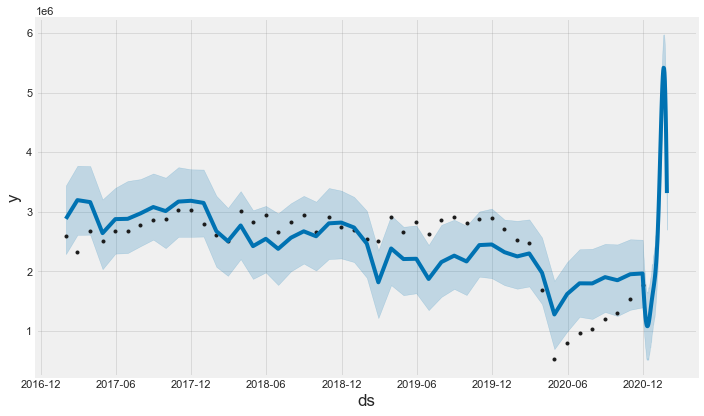

In [88]:
fig1 = m.plot(forecast)

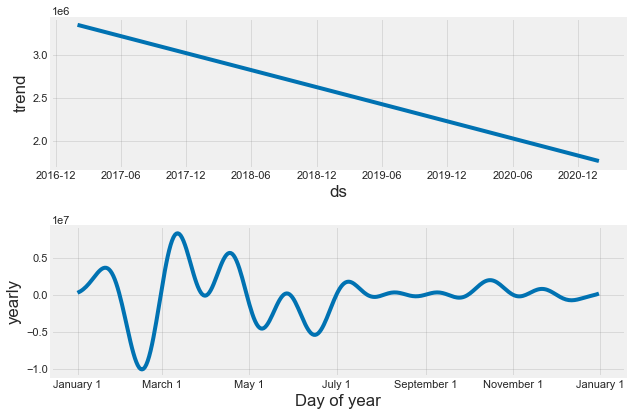

In [89]:
fig2 = m.plot_components(forecast)

In [90]:
from fbprophet.diagnostics import performance_metrics

In [91]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 2 forecasts with cutoffs between 2019-06-04 00:00:00 and 2019-12-01 00:00:00


INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-30,2.336002e+06,2.277608e+06,2.395815e+06,2628562,2019-06-04
1,2019-07-31,2.726808e+06,2.669246e+06,2.788577e+06,2868385,2019-06-04
2,2019-08-31,2.995751e+06,2.938104e+06,3.056269e+06,2920511,2019-06-04
3,2019-09-30,2.493925e+06,2.433250e+06,2.556123e+06,2804738,2019-06-04
4,2019-10-31,2.925151e+06,2.860174e+06,2.992406e+06,2883210,2019-06-04


In [92]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,30 days,5.124217e+10,226367.344781,211266.607833,0.079658,0.079658,0.0
1,57 days,1.846852e+10,135898.941645,135775.044042,0.048687,0.048687,0.0
2,61 days,1.567973e+10,125218.733440,123975.512751,0.045699,0.045699,0.0
3,88 days,8.488276e+09,92131.841981,90807.165431,0.033902,0.033902,0.0
4,90 days,3.080262e+09,55500.111487,48794.319049,0.017403,0.017403,0.5


Mientras que en el proyecto 3 teniamos un RMSE de 561045,94, observamos que para nuestro nuevo modelo con Prophet mejora considerablemente para 30, 57 y 61 días

---------

Queria pedir disculpas por la demora en la entrega del proyecto final, pero tuve complicaciones personales que fueron posponiendo la entrega del mismo.
Muchas gracias a todos! Gran Curso

#### A continuación les dejo el link del repositorio!

In [ ]:
https://github.com/Ima15/Acamica/blob/5798eacf050ed81028247719778ae1693c32e172/ProyectoFinal%20Imanol.ipynb